In [2]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from model_trainer.entities import ANOMALY_ARCHIVE_ENTITIES, MACHINES, MSL_CHANNELS, SMAP_CHANNELS, ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY
from metrics.metrics import METRICS_NAMES, evaluate_model_selection
from model_selection.rank_aggregation import trimmed_borda, trimmed_kemeny, borda, kemeny

from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import ndcg_score
from tqdm import tqdm 
from mallows import mallows_kendall as mk
from datetime import datetime
from pprint import pprint

In [3]:
SAVE_DIR = '/home/ubuntu/efs/results'

DATASETS = ['anomaly_archive', 'smd', 'msl', 'smap']
ENTITIES = [ANOMALY_ARCHIVE_ENTITIES, MACHINES, MSL_CHANNELS, SMAP_CHANNELS]
DATASET_ENTITY = dict(zip(DATASETS, ENTITIES))

In [63]:
dataset = 'smd'

stats = {}
for entity in tqdm(DATASET_ENTITY[dataset]): 
    ranking_obj_file = f'ranking_obj_{entity}.data'
    try:
        with open(os.path.join(SAVE_DIR, dataset, ranking_obj_file), 'rb') as f: 
            ranking_obj = pkl.load(f)
        
        ranks = ranking_obj.ranks_by_metrics.astype(int)
        rank_prauc = ranking_obj.rank_prauc.astype(int)
        rank_f1 = ranking_obj.rank_f1.astype(int)

    except: 
        continue
    
    if ranks.shape[1] != 19:
        print(entity, ranks.shape[1])
        continue

    # Get metric names
    metric_names = list(ranking_obj.models_performance_matrix.columns)
    metric_names.remove('PR-AUC')
    metric_names.remove('Best F-1')

    _, trimmed_kemeny_rank = trimmed_kemeny(ranks, metric='influence', aggregation_type='borda', verbose=False)
    trimmed_kemeny_rank = trimmed_kemeny_rank.astype(int)
    
    _, kemeny_rank = kemeny(ranks, verbose=False)
    kemeny_rank = kemeny_rank.astype(int)

    praucs = ranking_obj.models_performance_matrix.iloc[:, 0].to_numpy().squeeze()
    f1s = ranking_obj.models_performance_matrix.iloc[:, 1].to_numpy().squeeze()
    model_names = np.array(list(ranking_obj.models_performance_matrix.index))
    
    if np.std(praucs) == 0.0: # Bad datasets have 0.5 prauc for all models
        continue

    # if max(praucs) < 0.5: # Bad models
    #     continue
    
    s = {
        'Rank by PR-AUC': model_names[rank_prauc],
        'Rank by Best F-1': model_names[rank_f1],
        'Trimmed Aggregated rank': model_names[trimmed_kemeny_rank],
        'Trimmed Aggregated PR-AUCs': praucs[trimmed_kemeny_rank],
        'Trimmed Aggregated Best F-1': f1s[trimmed_kemeny_rank],
        'Untrimmed Aggregated rank': model_names[kemeny_rank],
        'Untrimmed Aggregated PR-AUCs': praucs[kemeny_rank],
        'Untrimmed Aggregated Best F-1': f1s[kemeny_rank],
        'Max PR-AUC': np.max(praucs),
        'Max Best F-1': np.max(f1s),
        'PR-AUCs': praucs,
        'Best F-1': f1s,
    }

    for i, mn in enumerate(metric_names):
        s[f'Predicted PR-AUCs ({mn})'] = praucs[ranks[i, :]]
        s[f'Predicted Best F-1 ({mn})'] = f1s[ranks[i, :]]

    stats[entity] = s

100%|██████████| 28/28 [00:23<00:00,  1.21it/s]


In [64]:
print(f'Number of datapoints: {len(stats.keys())}') 

Number of datapoints: 26


### Look at Random Datasets

In [15]:
entity = np.random.choice(list(stats.keys()))
# entity = '079_UCR_Anomaly_DISTORTEDresperation2'
print(f'Entity: {entity}')
print('Max Best F-1', stats[entity]['Max Best F-1'])
print('Best F-1', stats[entity]['Best F-1'])
print('Untrimmed Aggregated Best F-1', stats[entity]['Untrimmed Aggregated Best F-1'])
print('Trimmed Aggregated Best F-1', stats[entity]['Trimmed Aggregated Best F-1'])
# print('PR-AUCs', stats[entity]['PR-AUCs'])
# print('Max PR-AUC', stats[entity]['Max PR-AUC'])
# print('Untrimmed Aggregated PR-AUCs', stats[entity]['Untrimmed Aggregated PR-AUCs'])
# print('Trimmed Aggregated PR-AUCs', stats[entity]['Trimmed Aggregated PR-AUCs'])

Entity: 164_UCR_Anomaly_apneaecg3
Max Best F-1 0.18803245234830313
Best F-1 [0.1582719  0.18803245 0.14473548 0.06918172 0.11055171 0.16058244
 0.16296144 0.15384471 0.16922919 0.008121   0.00656906 0.00656906
 0.09865376 0.16541199 0.16058244 0.16417757 0.1718734  0.17886013
 0.16296144]
Untrimmed Aggregated Best F-1 [0.18803245 0.16541199 0.16296144 0.06918172 0.008121   0.09865376
 0.17886013 0.16417757 0.16058244 0.1718734  0.00656906 0.00656906
 0.16922919 0.16296144 0.15384471 0.14473548 0.11055171 0.16058244
 0.1582719 ]
Trimmed Aggregated Best F-1 [0.18803245 0.16417757 0.16058244 0.16296144 0.008121   0.09865376
 0.16296144 0.16541199 0.1718734  0.17886013 0.00656906 0.00656906
 0.16922919 0.16058244 0.15384471 0.14473548 0.06918172 0.11055171
 0.1582719 ]


In [65]:
aggregate_stats = {
    'Trimmed Aggregated PR-AUCs': [],  
    'Trimmed Aggregated Best F-1': [],
    'Untrimmed Aggregated PR-AUCs': [],  
    'Untrimmed Aggregated Best F-1': [],
    'Max PR-AUC': [],
    'Max Best F-1': [],
    'Expected PR-AUC': [],
    'Expected Best F-1': [],
    'Overall Best Model PR-AUC': [],
    'Overall Best Model F-1': [],
}

PRAUCS = []
F1S = []
for entity in stats.keys():
    PRAUCS.append(stats[entity]['PR-AUCs'])
    F1S.append(stats[entity]['Best F-1'])

PRAUCS = np.array(PRAUCS)
F1S = np.array(F1S)
best_model_idx_prauc = np.argmax(np.mean(PRAUCS, axis=0))
best_model_idx_f1 = np.argmax(np.mean(PRAUCS, axis=0))

for entity in stats.keys():
    aggregate_stats['Trimmed Aggregated PR-AUCs'].append(stats[entity]['Trimmed Aggregated PR-AUCs'][0]) 
    aggregate_stats['Trimmed Aggregated Best F-1'].append(stats[entity]['Trimmed Aggregated Best F-1'][0])
    aggregate_stats['Untrimmed Aggregated PR-AUCs'].append(stats[entity]['Untrimmed Aggregated PR-AUCs'][0]) 
    aggregate_stats['Untrimmed Aggregated Best F-1'].append(stats[entity]['Untrimmed Aggregated Best F-1'][0]) 
    aggregate_stats['Max PR-AUC'].append(stats[entity]['Max PR-AUC'])
    aggregate_stats['Max Best F-1'].append(stats[entity]['Max Best F-1'])
    aggregate_stats['Expected PR-AUC'].append(np.mean(stats[entity]['PR-AUCs']))
    aggregate_stats['Expected Best F-1'].append(np.mean(stats[entity]['Best F-1']))
    aggregate_stats['Overall Best Model PR-AUC'].append(stats[entity]['Best F-1'][best_model_idx_prauc])
    aggregate_stats['Overall Best Model F-1'].append(stats[entity]['Best F-1'][best_model_idx_f1])
    
for k, v in aggregate_stats.items():
    aggregate_stats[k] = np.array(v)

aggregate_stats['Expected/Max PR-AUCs'] = aggregate_stats['Expected PR-AUC']/aggregate_stats['Max PR-AUC']
aggregate_stats['Trimmed Aggregated/Max PR-AUCs'] = aggregate_stats['Trimmed Aggregated PR-AUCs']/aggregate_stats['Max PR-AUC']
aggregate_stats['Untrimmed Aggregated/Max PR-AUCs'] = aggregate_stats['Untrimmed Aggregated PR-AUCs']/aggregate_stats['Max PR-AUC']
aggregate_stats['Overall Best/Max PR-AUCs'] = aggregate_stats['Overall Best Model PR-AUC']/aggregate_stats['Max PR-AUC']

aggregate_stats['Overall Best/Max Best F-1'] = aggregate_stats['Overall Best Model F-1']/(aggregate_stats['Max Best F-1'] + 1e-6)
aggregate_stats['Expected/Max Best F-1'] = aggregate_stats['Expected Best F-1']/(aggregate_stats['Max Best F-1'] + 1e-6)
aggregate_stats['Trimmed Aggregated/Max Best F-1'] = aggregate_stats['Trimmed Aggregated Best F-1']/(aggregate_stats['Max Best F-1'] + 1e-6)
aggregate_stats['Untrimmed Aggregated/Max Best F-1'] = aggregate_stats['Untrimmed Aggregated Best F-1']/(aggregate_stats['Max Best F-1'] + 1e-6)

aggregate_stats['Overall Best/Max PR-AUCs'][aggregate_stats['Overall Best/Max PR-AUCs'] > 1] = 1
aggregate_stats['Overall Best/Max Best F-1'][aggregate_stats['Overall Best/Max Best F-1'] > 1] = 1
aggregate_stats['Expected/Max Best F-1'][aggregate_stats['Expected/Max Best F-1'] > 1] = 1
aggregate_stats['Trimmed Aggregated/Max Best F-1'][aggregate_stats['Trimmed Aggregated/Max Best F-1'] > 1] = 1
aggregate_stats['Untrimmed Aggregated/Max Best F-1'][aggregate_stats['Untrimmed Aggregated/Max Best F-1'] > 1] = 1

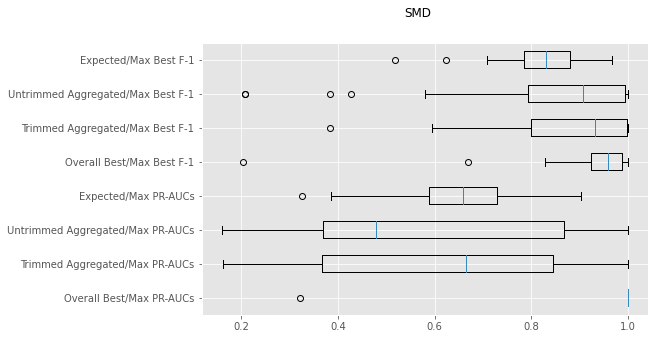

In [78]:
plt.style.use('ggplot')
result_type = 'box_plot'

fig, axes = plt.subplots(1, 1, figsize=(8, 5))
fig.suptitle(' '.join(dataset.split('_')).upper())
_ = plt.boxplot([aggregate_stats['Overall Best/Max PR-AUCs'],
                 aggregate_stats['Trimmed Aggregated/Max PR-AUCs'],
                 aggregate_stats['Untrimmed Aggregated/Max PR-AUCs'],
                 aggregate_stats['Expected/Max PR-AUCs'],
                 aggregate_stats['Overall Best/Max Best F-1'],
                 aggregate_stats['Trimmed Aggregated/Max Best F-1'],
                 aggregate_stats['Untrimmed Aggregated/Max Best F-1'],
                 aggregate_stats['Expected/Max Best F-1'],
                ], 
                 vert=False, 
                 bootstrap=1000,
                 labels=[
                    'Overall Best/Max PR-AUCs',
                    'Trimmed Aggregated/Max PR-AUCs', 
                    'Untrimmed Aggregated/Max PR-AUCs', 
                    'Expected/Max PR-AUCs',
                    'Overall Best/Max Best F-1',
                    'Trimmed Aggregated/Max Best F-1', 
                    'Untrimmed Aggregated/Max Best F-1', 
                    'Expected/Max Best F-1',
                    ])
plt.savefig(f"results_{result_type}_{dataset}_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.png", bbox_inches='tight')

### Look at Results of Random Entities from a Dataset

In [37]:
dataset = 'smd'
entity = np.random.choice(a=DATASET_ENTITY[dataset], size=1)[0]
# entity = 'T-4'
print(f'Results for entity: {entity}')

result_file = f'results_{entity}.csv'
ranking_obj_file = f'ranking_obj_{entity}.data'

result = pd.read_csv(os.path.join(SAVE_DIR, dataset, result_file))
result.index = METRICS_NAMES
result

Results for entity: machine-3-10


,Borda,Trimmed Borda (proximity),Trimmed Borda (influence),Trimmed Borda (pagerank),Kemeny,Trimmed Kemeny (proximity),Trimmed Kemeny (influence),Trimmed Kemeny (pagerank),MAE,MSE,...,SYNTHETIC_KENDALL_TAU_5453,SYNTHETIC_KENDALL_TAU_4816,SYNTHETIC_KENDALL_TAU_9942,SYNTHETIC_KENDALL_TAU_485,SYNTHETIC_KENDALL_TAU_6250,SYNTHETIC_KENDALL_TAU_9067,SYNTHETIC_KENDALL_TAU_3182,SYNTHETIC_KENDALL_TAU_7153,SYNTHETIC_KENDALL_TAU_1400,SYNTHETIC_KENDALL_TAU_7930
PR-AUC of Top-1 Predicted Model,0.789457,0.777492,0.783055,0.777492,0.736646,0.736646,0.737657,0.736646,0.261786,0.261786,...,0.465884,0.736646,0.465608,0.465884,0.736646,0.465831,0.736646,0.730865,0.729848,0.737657
PR-AUC of Top-k Predicted Model,0.692102,0.688349,0.636197,0.688349,0.726120,0.726120,0.671968,0.726120,0.316787,0.316787,...,0.627129,0.680180,0.627118,0.574325,0.726120,0.574325,0.726120,0.680180,0.625770,0.680180
Average PR-AUC,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,...,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062,0.557062
Range of PR-AUC,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,...,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374,0.530374
PR-AUC of Best Model,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,...,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159,0.792159
PR-AUC of Top-3 Best Models,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,...,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964,0.775964
Kendall's Tau Corr.,-0.146199,-0.122807,-0.134503,-0.122807,-0.192982,-0.169591,-0.181287,-0.169591,0.228070,0.228070,...,-0.111111,-0.181287,-0.040936,-0.029240,-0.204678,-0.052632,-0.251462,-0.040936,-0.111111,-0.146199


In [7]:
with open(os.path.join(SAVE_DIR, dataset, ranking_obj_file), 'rb') as f: 
    ranking_obj = pkl.load(f)

ranks = ranking_obj.ranks_by_metrics[8:, :]

n_metrics, _ = ranks.shape
top_k_percent_cutoffs = np.around(n_metrics*np.array([20, 30, 40, 50, 60, 70])/100).astype(np.int32)
metric = 'influence'

# PR-AUC of each model
prauc = ranking_obj.models_performance_matrix.loc[:, 'PR-AUC'].to_numpy()

for TOP_K in top_k_percent_cutoffs:
    print(f'Considering top-{TOP_K} ranks')
    obj, trimmed_kemeny_rank = trimmed_kemeny(ranks, weights=None, top_k=TOP_K, aggregation_type='kemeny', metric=metric, verbose=False)
    print(trimmed_kemeny_rank)
    trimmed_kemeny_rank=trimmed_kemeny_rank.astype(np.int32)
    eval_result = evaluate_model_selection(prauc, trimmed_kemeny_rank, 5)
    print(f"PR-AUC of Top-1 Predicted Model={eval_result['PR-AUC of Top-1 Predicted Model']} | Objective: {obj} | PR-AUC of Best Model={eval_result['PR-AUC of Best Model']}") 

Considering top-6 ranks
[10. 11.  9.  5.  6.  8.  7. 14. 13. 16. 17. 18. 15.  1.  2.  0.  3. 12.
  4.]
PR-AUC of Top-1 Predicted Model=0.10167599340860131 | Objective: 39.5 | PR-AUC of Best Model=0.49651522489466277
Considering top-8 ranks
[11. 12. 10.  5.  6.  8.  7. 15.  9. 16. 17. 18. 14.  4.  2.  0.  1. 13.
  3.]
PR-AUC of Top-1 Predicted Model=0.09735518514642658 | Objective: 41.0 | PR-AUC of Best Model=0.49651522489466277
Considering top-11 ranks
[10.  9.  8.  4.  5.  7.  6. 17. 14. 15. 16. 18. 13.  3. 12.  0.  1. 11.
  2.]
PR-AUC of Top-1 Predicted Model=0.10167599340860131 | Objective: 46.18181818181818 | PR-AUC of Best Model=0.49651522489466277
Considering top-14 ranks
[11. 10.  9.  4.  8.  7.  6. 17. 15. 14. 16. 18. 13.  3.  5.  0.  1. 12.
  2.]
PR-AUC of Top-1 Predicted Model=0.09735518514642658 | Objective: 52.214285714285715 | PR-AUC of Best Model=0.49651522489466277
Considering top-17 ranks
[11. 10.  9.  7.  6.  5.  8. 16. 15. 14. 17. 18. 13.  3. 12.  0.  1.  4.
  2.]
PR-

In [50]:
### Baselines
from tqdm import tqdm

class ModelSelectionResults(object):
    def __init__(self, 
                 dataset_name:str='msl', 
                 results_dir:str='/home/ubuntu/efs/results'):
        self.dataset_name = dataset_name
        self.results_dir = results_dir
        self.entities = DATASET_ENTITY[self.dataset_name]
        
        self.ranking_objects = {}
        self.result_dfs = {}
        self.praucs_entity = {}
        
        for ent in tqdm(self.entities): 
            result_file = f'results_{ent}.csv'
            ranking_obj_file = f'ranking_obj_{ent}.data'
            
            if (os.path.exists(os.path.join(self.results_dir, self.dataset_name, result_file))) and (os.path.exists(os.path.join(self.results_dir, self.dataset_name, ranking_obj_file))):
                self.result_dfs[ent] = pd.read_csv(os.path.join(self.results_dir, self.dataset_name, result_file))
                self.result_dfs[ent].index = METRICS_NAMES
                with open(os.path.join(self.results_dir, self.dataset_name, ranking_obj_file), 'rb') as f: 
                    self.ranking_objects[ent] = pkl.load(f)

                self.praucs_entity[ent] = self.ranking_objects[ent].models_performance_matrix.loc[:, 'PR-AUC']
            else:
                self.entities.remove(ent)

        self.praucs = pd.concat(list(self.praucs_entity.values()), axis=1).to_numpy()

        # PR-AUCs based on our model selection strategy
        self.top_1_praucs = []
        self.top_k_praucs = []
        self.top_1_praucs_trimmed = []
        self.top_k_praucs_trimmed = []
        
    def expected_model_set_perf_on_dataset(self)->float:
        """Average PR-AUC of all models across all entities belonging to a dataset. 
        This denotes the expected performance of a randomly chosen model in the dataset. 
        """
        return np.nanmean(self.praucs)
    
    def expected_model_set_perf_per_entity(self)->np.ndarray:
        """Average PR-AUC of all models on each entity. 
        This denotes the expected performance of a randomly chosen model on an entity. 
        """
        return np.nanmean(self.praucs, axis=0)

    def best_model_perf_for_each_entity(self)->np.ndarray:
        """Performance of best model for each entity
        """
        return np.max(self.praucs, axis=0)
    
    def top_k_best_model_perf_for_each_entity(self, top_k=5)->np.ndarray:
        """Average PR-AUC of the top-k best models for each entity in the dataset. 
        """
        temp_praucs = np.array([sorted(self.praucs[:, i], reverse=True) for i in range(self.praucs.shape[1])]).T
        return np.mean(temp_praucs[:top_k, :], axis=0)
    
    def perf_best_model_overall(self)->np.ndarray:
        """Maximum PR-AUC if a single model is used for every entity. 
        """
        return self.praucs[np.argmax(np.nanmean(self.praucs, axis=1)), :] 

    def expected_top_k_best_models_overall(self, top_k=5)->np.ndarray:
        """Expected PR-AUC when the top-k best models overall are used for every entity. 
        """
        return np.nanmean(self.praucs[np.argsort(-1*np.nanmean(self.praucs, axis=1))[:top_k], :], axis=0)

    def select_best_model(self, consider_top_ranks:float=60, metric:str='influence', aggregation_type='kemeny', top_k=5):
        top_1_praucs = []
        top_k_praucs = []
        top_1_praucs_trimmed = []
        top_k_praucs_trimmed = []
        for ent in tqdm(self.entities): 
            n_metrics, _ = self.ranking_objects[ent].ranks_by_metrics.shape
            _, trimmed_kemeny_rank = trimmed_kemeny(self.ranking_objects[ent].ranks_by_metrics, 
                                                    weights=None, 
                                                    top_k=int((consider_top_ranks*n_metrics)/100), 
                                                    aggregation_type=aggregation_type, 
                                                    metric=metric, 
                                                    verbose=False)
            trimmed_kemeny_rank=trimmed_kemeny_rank.astype(np.int32)
            eval_result = evaluate_model_selection(self.praucs_entity[ent].squeeze(), trimmed_kemeny_rank, top_k)
            top_1_praucs_trimmed.append(eval_result['PR-AUC of Top-1 Predicted Model'])
            top_k_praucs_trimmed.append(eval_result['PR-AUC of Top-k Predicted Model'])
            
            _, kemeny_rank = kemeny(self.ranking_objects[ent].ranks_by_metrics, weights=None, verbose=False)
            kemeny_rank=kemeny_rank.astype(np.int32)
            eval_result = evaluate_model_selection(self.praucs_entity[ent].squeeze(), kemeny_rank, top_k)
            top_1_praucs.append(eval_result['PR-AUC of Top-1 Predicted Model'])
            top_k_praucs.append(eval_result['PR-AUC of Top-k Predicted Model'])

        self.top_1_praucs_trimmed = np.array(top_1_praucs_trimmed)
        self.top_k_praucs_trimmed = np.array(top_k_praucs_trimmed)
        self.top_1_praucs = np.array(top_1_praucs)
        self.top_k_praucs = np.array(top_k_praucs)
        
        return self.top_1_praucs_trimmed, self.top_k_praucs_trimmed, self.top_1_praucs, self.top_k_praucs

In [51]:
result_object = ModelSelectionResults(dataset_name='msl', results_dir='/home/ubuntu/efs/results')

100%|██████████| 27/27 [00:00<00:00, 27.82it/s]


In [52]:
_expected_model_set_perf_on_dataset = result_object.expected_model_set_perf_on_dataset()
_expected_model_set_perf_per_entity = result_object.expected_model_set_perf_per_entity()
_best_model_perf_for_each_entity = result_object.best_model_perf_for_each_entity()
_top_k_best_model_perf_for_each_entity = result_object.top_k_best_model_perf_for_each_entity(top_k=5)
_perf_best_model_overall = result_object.perf_best_model_overall()
_expected_top_k_best_models_overall = result_object.expected_top_k_best_models_overall(top_k=5)

top_1_praucs_trimmed, top_k_praucs_trimmed, top_1_praucs, top_k_praucs = result_object.select_best_model(consider_top_ranks=60, metric='influence', aggregation_type='kemeny', top_k=5)

100%|██████████| 27/27 [01:47<00:00,  3.99s/it]


In [53]:
results = [
    top_1_praucs_trimmed.reshape((-1, 1)),
    top_1_praucs.reshape((-1, 1)), 
    _best_model_perf_for_each_entity.reshape((-1, 1)),
    _perf_best_model_overall.reshape((-1, 1)),
    top_k_praucs_trimmed.reshape((-1, 1)),
    top_k_praucs.reshape((-1, 1)),
    _top_k_best_model_perf_for_each_entity.reshape((-1, 1)),
    _expected_top_k_best_models_overall.reshape((-1, 1)),
    _expected_model_set_perf_per_entity.reshape((-1, 1)),]

results = np.concatenate(results, axis=1)
columns = [
    'PR-AUC of Trimmed Top-1 Selected Model', 
    'PR-AUC of Top-1 Selected Model', 
    'PR-AUC of Top-1 Best Model', 
    'PR-AUC of Overall Best Model',
    'Mean PR-AUC of Trimmed Top-k Selected Models', 
    'Mean PR-AUC of Top-k Selected Models', 
    'Mean PR-AUC of Top-k Best Models', 
    'Mean PR-AUC of Overall Top-k Best Models',
    'Expected PR-AUC of Models', 
    ]

In [56]:
results = pd.DataFrame(results, columns=columns)
results.index = result_object.entities
results.to_csv(os.path.join(result_object.results_dir, f'{result_object.dataset_name}.csv'), index=None)
# categories = [ANOMALY_ARCHIVE_ENTITY_TO_DATA_FAMILY[i] for i in result_object.entities]
# results.loc[:, 'Family'] = categories
results.sort_values(by=['PR-AUC of Trimmed Top-1 Selected Model'])

,PR-AUC of Trimmed Top-1 Selected Model,PR-AUC of Top-1 Selected Model,PR-AUC of Top-1 Best Model,PR-AUC of Overall Best Model,Mean PR-AUC of Trimmed Top-k Selected Models,Mean PR-AUC of Top-k Selected Models,Mean PR-AUC of Top-k Best Models,Mean PR-AUC of Overall Top-k Best Models,Expected PR-AUC of Models
F-8,0.038074,0.038074,0.269675,0.269675,0.144006,0.144006,0.253904,0.252000,0.139762
T-4,0.052986,0.346401,0.517272,0.346401,0.118885,0.320890,0.338623,0.322182,0.133657
P-10,0.100374,0.100374,0.694794,0.457747,0.108225,0.121666,0.621558,0.417495,0.335067
M-5,0.109427,0.169921,0.250462,0.250462,0.140544,0.157427,0.198951,0.144391,0.093131
T-8,0.110647,0.281549,0.505163,0.505163,0.070816,0.104997,0.383898,0.380314,0.148656
D-15,0.141784,0.141784,0.491021,0.239266,0.203743,0.203743,0.341927,0.272119,0.213380
T-13,0.155643,0.103468,0.478586,0.378138,0.262971,0.288650,0.430934,0.377161,0.305207
C-1,0.234451,0.244354,0.244354,0.212997,0.183315,0.189915,0.222202,0.200506,0.165161
M-3,0.234998,0.035527,0.470396,0.302334,0.253094,0.228429,0.409071,0.220963,0.234954
D-16,0.277723,0.163943,0.388427,0.277723,0.220920,0.240478,0.308225,0.229596,0.180928


In [55]:
results.mean()

PR-AUC of Trimmed Top-1 Selected Model          0.385419
PR-AUC of Top-1 Selected Model                  0.320855
PR-AUC of Top-1 Best Model                      0.568850
PR-AUC of Overall Best Model                    0.469692
Mean PR-AUC of Trimmed Top-k Selected Models    0.314362
Mean PR-AUC of Top-k Selected Models            0.315608
Mean PR-AUC of Top-k Best Models                0.491692
Mean PR-AUC of Overall Top-k Best Models        0.418476
Expected PR-AUC of Models                       0.300910
dtype: float64

SMD
PR-AUC of Trimmed Top-1 Selected Model          0.426460
PR-AUC of Top-1 Selected Model                  0.437811
PR-AUC of Top-1 Best Model                      0.566476
PR-AUC of Overall Best Model                    0.463080
Mean PR-AUC of Trimmed Top-k Selected Models    0.417421
Mean PR-AUC of Top-k Selected Models            0.409999
Mean PR-AUC of Top-k Best Models                0.518649
Mean PR-AUC of Overall Top-k Best Models        0.453346
Expected PR-AUC of Models                       0.370503

MSL
PR-AUC of Trimmed Top-1 Selected Model          0.388188
PR-AUC of Top-1 Selected Model                  0.377539
PR-AUC of Top-1 Best Model                      0.568850
PR-AUC of Overall Best Model                    0.469692
Mean PR-AUC of Trimmed Top-k Selected Models    0.326370
Mean PR-AUC of Top-k Selected Models            0.311044
Mean PR-AUC of Top-k Best Models                0.491692
Mean PR-AUC of Overall Top-k Best Models        0.418476
Expected PR-AUC of Models                       0.300910

In [300]:
## For the anomaly archive
results.iloc[:, :-1].mean()

for fam in np.unique(results.Family):
    print(f'\nFamily: {fam}')
    print(results.loc[results['Family'] == fam].iloc[:, :-1].median())

PR-AUC of Trimmed Top-1 Selected Model          0.331097
PR-AUC of Top-1 Selected Model                  0.328034
PR-AUC of Top-1 Best Model                      0.515313
PR-AUC of Overall Best Model                    0.480406
Mean PR-AUC of Trimmed Top-k Selected Models    0.320298
Mean PR-AUC of Top-k Selected Models            0.309630
Mean PR-AUC of Top-k Best Models                0.451634
Mean PR-AUC of Overall Top-k Best Models        0.393567
Expected PR-AUC of Models                       0.278024
dtype: float64

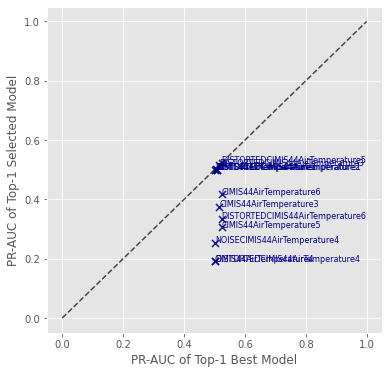

In [297]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
X = np.linspace(0, 1.0, 10)

res = results.loc[results['Family'] == 'Air Temperature']
# fig.suptitle(f'Aggregator: {aggregation}', fontsize=16)
axes.scatter(res.loc[:, 'PR-AUC of Top-1 Best Model'], res.loc[:, 'PR-AUC of Top-1 Selected Model'], alpha=0.9, marker='x', s=50, color='darkblue')
axes.plot(X, X, 'k--', alpha=0.7)
axes.set_ylabel('PR-AUC of Top-1 Selected Model', fontsize=12)
axes.set_xlabel('PR-AUC of Top-1 Best Model', fontsize=12)

for i in range(res.shape[0]):
    entity_name = res.index[i]
    axes.text(res.loc[entity_name, 'PR-AUC of Top-1 Best Model'], res.loc[entity_name, 'PR-AUC of Top-1 Selected Model'], entity_name.split('_')[-1], fontsize=8, c='darkblue')

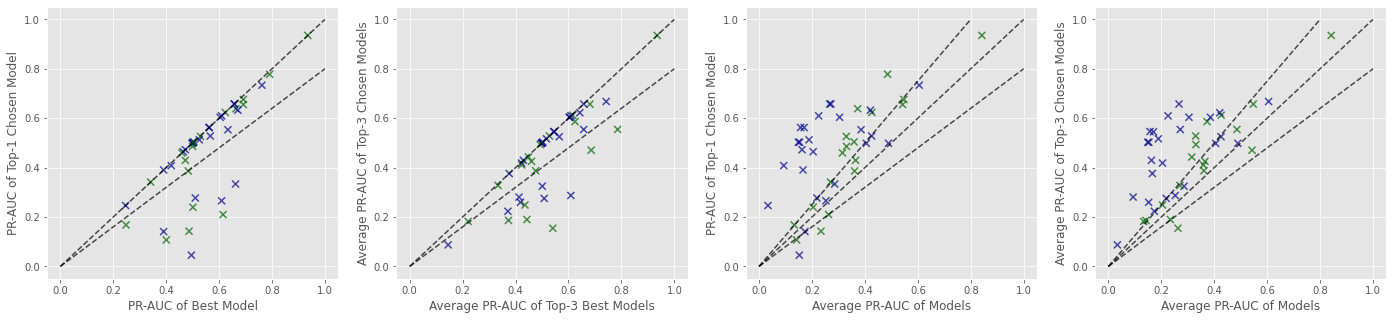

In [78]:
plt.style.use('ggplot')

# aggregation = 'Trimmed Kemeny (influence)'
aggregation = ['Borda', 'Trimmed Borda (proximity)', 'Trimmed Borda (influence)', 'Trimmed Borda (pagerank)', 'Kemeny', 'Trimmed Kemeny (proximity)', 'Trimmed Kemeny (influence)', 'Trimmed Kemeny (pagerank)']

colors = ['darkblue' if i == 'anomaly_archive' else 'darkgreen' for i in datasets]

prauc_top1_pred = []
prauc_top1_best = []
prauc_top3_pred = []
prauc_top3_best = []

average_prauc = []
for f in data_files: 
    result = pd.read_csv(os.path.join(SAVE_DIR, f))
    result.index = METRICS_NAMES

    prauc_top1_pred.append( result.loc['PR-AUC of Top-1 Predicted Model', aggregation].max() )
    prauc_top1_best.append( result.loc['PR-AUC of Best Model', aggregation].max() )
    prauc_top3_pred.append( result.loc['PR-AUC of Top-k Predicted Model', aggregation].max() )
    prauc_top3_best.append( result.loc['PR-AUC of Top-3 Best Models', aggregation].max() )
    average_prauc.append( result.loc['Average PR-AUC', aggregation].max() )

prauc_top1_pred = np.array(prauc_top1_pred)
prauc_top1_best = np.array(prauc_top1_best)
prauc_top3_pred = np.array(prauc_top3_pred)
prauc_top3_best = np.array(prauc_top3_best)

fig, axes = plt.subplots(1, 4, figsize=(24, 5))
X = np.linspace(0, 1.0, 10)
# fig.suptitle(f'Aggregator: {aggregation}', fontsize=16)
axes[0].scatter(prauc_top1_best, prauc_top1_pred, c=colors, alpha=0.7, marker='x', s=50)
axes[0].plot(X, X, 'k--', alpha=0.7)
axes[0].plot(X, 0.8*X, 'k--', alpha=0.7)
axes[0].set_ylabel('PR-AUC of Top-1 Chosen Model', fontsize=12)
axes[0].set_xlabel('PR-AUC of Best Model', fontsize=12)

axes[1].scatter(prauc_top3_best, prauc_top3_pred, c=colors, alpha=0.7, marker='x', s=50)
axes[1].plot(X, X, 'k--', alpha=0.7)
axes[1].plot(X, 0.8*X, 'k--', alpha=0.7)
axes[1].set_ylabel('Average PR-AUC of Top-3 Chosen Models', fontsize=12)
axes[1].set_xlabel('Average PR-AUC of Top-3 Best Models', fontsize=12)

axes[2].scatter(average_prauc, prauc_top1_pred, c=colors, alpha=0.7, marker='x', s=50)
axes[2].plot(X, X, 'k--', alpha=0.7)
axes[2].plot(0.8*X, X, 'k--', alpha=0.7)
axes[2].plot(X, 0.8*X, 'k--', alpha=0.7)
axes[2].set_ylabel('PR-AUC of Top-1 Chosen Model', fontsize=12)
axes[2].set_xlabel('Average PR-AUC of Models', fontsize=12)

axes[3].scatter(average_prauc, prauc_top3_pred, c=colors, alpha=0.7, marker='x', s=50)
axes[3].plot(X, X, 'k--', alpha=0.7)
axes[3].plot(0.8*X, X, 'k--', alpha=0.7)
axes[3].plot(X, 0.8*X, 'k--', alpha=0.7)
axes[3].set_ylabel('Average PR-AUC of Top-3 Chosen Models', fontsize=12)
axes[3].set_xlabel('Average PR-AUC of Models', fontsize=12)

plt.savefig(os.path.join(SAVE_DIR, f'results_{aggregation}.pdf'))

### Summary Results

In [79]:
DATASET = 'smd' # 'anomaly_archive' 'smd'
idxs = np.where(datasets == DATASET)[0]

average_result_dict = {}
average_result_dict['PR-AUC of Top-1 Chosen Model'] = {
    'Mean': np.around(np.mean(prauc_top1_pred[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_top1_pred[idxs]), 3),
    'Median': np.around(np.median(prauc_top1_pred[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_top1_pred[idxs], 0.75) - np.quantile(prauc_top1_pred[idxs], 0.25), 3),
}
average_result_dict['PR-AUC of Best Model'] = {
    'Mean': np.around(np.mean(prauc_top1_best[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_top1_best[idxs]), 3),
    'Median': np.around(np.median(prauc_top1_best[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_top1_best[idxs], 0.75) - np.quantile(prauc_top1_best[idxs], 0.25), 3),
}
average_result_dict['PR-AUC of Top-3 Chosen Models'] = {
    'Mean': np.around(np.mean(prauc_top3_pred[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_top3_pred[idxs]), 3),
    'Median': np.around(np.median(prauc_top3_pred[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_top3_pred[idxs], 0.75) - np.quantile(prauc_top3_pred[idxs], 0.25), 3),
}
average_result_dict['PR-AUC of Top-3 Best Models'] = {
    'Mean': np.around(np.mean(prauc_top3_best[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_top3_best[idxs]), 3),
    'Median': np.around(np.median(prauc_top3_best[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_top3_best[idxs], 0.75) - np.quantile(prauc_top3_best[idxs], 0.25), 3),
}
average_result_dict['PR-AUC of Best Model Overall'] = {
    'Mean': np.around(np.mean(prauc_best_model_overall[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_best_model_overall[idxs]), 3),
    'Median': np.around(np.median(prauc_best_model_overall[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_best_model_overall[idxs], 0.75) - np.quantile(prauc_best_model_overall[idxs], 0.25), 3),
}
average_result_dict['PR-AUC of Top-3 Best Model Overall'] = {
    'Mean': np.around(np.mean(prauc_top_3_best_model_overall[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_top_3_best_model_overall[idxs]), 3),
    'Median': np.around(np.median(prauc_top_3_best_model_overall[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_top_3_best_model_overall[idxs], 0.75) - np.quantile(prauc_top_3_best_model_overall[idxs], 0.25), 3),
}

average_result_dict['PR-AUC of Median Best Model Overall'] = {
    'Mean': np.around(np.mean(prauc_median_model_overall[idxs]), 3),
    'Standard Deviation': np.around(np.std(prauc_median_model_overall[idxs]), 3),
    'Median': np.around(np.median(prauc_median_model_overall[idxs]), 3),
    'IQR': np.around(np.quantile(prauc_median_model_overall[idxs], 0.75) - np.quantile(prauc_median_model_overall[idxs], 0.25), 3),
}
average_result_dict['PR-AUC of All Models'] = {
    'Mean': np.around(np.nanmean(model_praucs[:, idxs]), 3),
    'Standard Deviation': np.around(np.nanstd(model_praucs[:, idxs]), 3),
    'Median': np.around(np.nanmedian(model_praucs[:, idxs]), 3),
    'IQR': np.around(np.nanquantile(model_praucs[:, idxs], 0.75) - np.nanquantile(model_praucs[:, idxs], 0.25), 3),
}

In [80]:
df = pd.DataFrame(average_result_dict)
df.to_csv(os.path.join(SAVE_DIR, f'{DATASET}_25_results.csv'), index=None)
df

,PR-AUC of Top-1 Chosen Model,PR-AUC of Best Model,PR-AUC of Top-3 Chosen Models,PR-AUC of Top-3 Best Models,PR-AUC of Best Model Overall,PR-AUC of Top-3 Best Model Overall,PR-AUC of Median Best Model Overall,PR-AUC of All Models
Mean,0.461,0.552,0.433,0.528,0.324,0.312,0.423,0.362
Standard Deviation,0.226,0.159,0.196,0.166,0.128,0.129,0.209,0.207
Median,0.473,0.503,0.434,0.484,0.287,0.320,0.400,0.342
IQR,0.369,0.178,0.279,0.185,0.178,0.165,0.236,0.271


### Observations
1. Trimmed estimators perform better than their untrimmed counterparts, but to varying degrees. The difference is much smaller in case of Kemeny Aggregation as compared to Borda aggregation. 
2. Influence is empirically the best measure of reliability, followed by pagerank and finally proximity. 

Text(0.5, 0, 'PR-AUC of Median Model Overall')

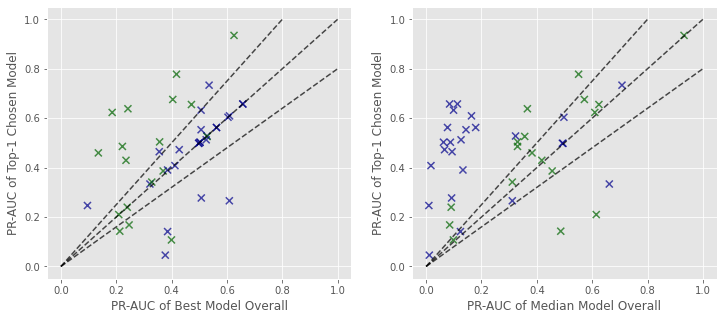

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
X = np.linspace(0, 1.0, 10)
# fig.suptitle(f'Aggregator: {aggregation}', fontsize=16)
axes[0].scatter(prauc_best_model_overall, prauc_top1_pred, c=colors, alpha=0.7, marker='x', s=50)
axes[0].plot(X, X, 'k--', alpha=0.7)
axes[0].plot(X, 0.8*X, 'k--', alpha=0.7)
axes[0].plot(0.8*X, X, 'k--', alpha=0.7)
axes[0].set_ylabel('PR-AUC of Top-1 Chosen Model', fontsize=12)
axes[0].set_xlabel('PR-AUC of Best Model Overall', fontsize=12)

axes[1].scatter(prauc_median_model_overall, prauc_top1_pred, c=colors, alpha=0.7, marker='x', s=50)
axes[1].plot(X, X, 'k--', alpha=0.7)
axes[1].plot(X, 0.8*X, 'k--', alpha=0.7)
axes[1].plot(0.8*X, X, 'k--', alpha=0.7)
axes[1].set_ylabel('PR-AUC of Top-1 Chosen Model', fontsize=12)
axes[1].set_xlabel('PR-AUC of Median Model Overall', fontsize=12)

In [254]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle(f'SMD Datset')
_ = plt.boxplot([ndcg_scores,
                 np.array(chosen_praucs)/np.array(max_praucs),
                 np.array(best_model_1_praucs)/np.array(max_praucs),  
                 average_model_praucs,
                 chosen_praucs,
                 best_model_5_praucs, 
                 best_model_4_praucs, 
                 best_model_3_praucs, 
                 best_model_2_praucs, 
                 best_model_1_praucs, 
                 max_praucs], 
                 vert=False, 
                 bootstrap=10000,
                 labels=['NDCG scores', r'Chosen/Max PR-AUC', r'Overall Best/Max PR-AUC', 
                         'Expected PR-AUC', 'Chosen Model PR-AUCs', 
                         'Top-5 Overall Best Model PR-AUCs',
                         'Top-4 Overall Best Model PR-AUCs',
                         'Top-3 Overall Best Model PR-AUCs',
                         'Top-2 Overall Best Model PR-AUCs',
                         'Top-1 Overall Best Model PR-AUCs', 
                         'Max PR-AUCs'])